In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from tqdm import tqdm_notebook
import io
from PIL import Image
from glob import glob
from collections import defaultdict
import os
import pickle
from io import BytesIO
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset
from torch.utils.data import Dataset

from kaggle_camera_model_id_lib.utils import PechkaBot, ImageList, NpzFolder, NCrops, TifFolderExFiles
from kaggle_camera_model_id_lib.models import VggHead, StyleVggHead, IEEEfcn, ResNetFC, FatNet1
from kaggle_camera_model_id_lib.utils import jpg_compress, equalize_v_hist, hsv_convert
from kaggle_camera_model_id_lib.utils import scale_crop_pad, gamma_correction, MultiDataset
from kaggle_camera_model_id_lib.utils import patch_quality_dich, n_random_crops, n_pseudorandom_crops

import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
val_path = '/home/mephistopheies/storage2/data/camera-model-id/val/'
test_path = '/home/mephistopheies/storage2/data/camera-model-id/raw/test/'
model_path = '/home/mephistopheies/storage2/data/camera-model-id/models/resnet34fc/256_pretrained_random_aug_kaggle_10/best_model.tar'
out_dir = '/home/mephistopheies/storage2/data/camera-model-id/submit/'
model_type = 'resnet34fc_pretrained'
n_classes = 10
crop_size = 256
step = 128
num_workers = 1

do_random_aug_kaggle = True
p_random_aug_kaggle = 0.5
do_hard_aug = True
p_hard_aug = 0.5

to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

scale_05 = lambda img: scale_crop_pad(img, 0.5)
scale_08 = lambda img: scale_crop_pad(img, 0.8)
scale_15 = lambda img: scale_crop_pad(img, 1.5)
scale_20 = lambda img: scale_crop_pad(img, 2.0)
gamma_08 = lambda img: gamma_correction(img, 0.8)
gamma_12 = lambda img: gamma_correction(img, 1.2)
jpg_70 = lambda img: jpg_compress(img, (70, 71))
jpg_90 = lambda img: jpg_compress(img, (90, 91))
augs = [scale_05, scale_08, scale_15, scale_20, gamma_08, gamma_12, jpg_70, jpg_90]

blur = iaa.GaussianBlur(sigma=(0, 2))
sharpen = iaa.Sharpen(alpha=(0, 1), lightness=(0.5, 2))
emboss = iaa.Emboss(alpha=(0, 1), strength=(0, 2))
contrast_normalization = iaa.ContrastNormalization(alpha=(0.7, 1.3))
hard_aug = iaa.OneOf([blur, sharpen, emboss, contrast_normalization])
sometimes = iaa.Sometimes(p_hard_aug, hard_aug)


def random_aug_kaggle(img, p=0.5):
    if np.random.rand() < p:
        return random.choice(augs)(img)
    return img

def aug_train(img):
    if min(img.size) > crop_center_size:
        return random_flip(random_crop(center_crop(img)))
    return random_flip(random_crop(img))

def aug_optional(img):
    if do_hard_aug:
        img = Image.fromarray(sometimes.augment_image(np.array(img)))

    if do_random_aug_kaggle:
        img = random_aug_kaggle(img, p_random_aug_kaggle)
    return img

In [3]:
model_factory = {
    'Vgg19Head_E_2b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_2b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_3b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_3b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='E', batch_norm=True),
    'Vgg11Head_A_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=True),
    'Vgg11Head_A': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=False),
    'StyleVggHead_bn': lambda n_classes: StyleVggHead(num_classes=n_classes, load_vgg_bn=True),
    'IEEEfcn': lambda n_classes: IEEEfcn(n_classes),
    'resnet18fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'resnet18fc': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet=None),
    'resnet18X_pretrained': lambda n_classes: ResNetX(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'InceptionResNetV2fc_5_10_4': lambda n_classes: InceptionResNetV2fc(
        num_classes=n_classes, nun_block35=5, num_block17=10, num_block8=4),
    'InceptionResNetV2fcSmall_5_10': lambda n_classes: InceptionResNetV2fcSmall(
        num_classes=n_classes, nun_block35=5, num_block17=10),
    'resnet34fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34'),
    'resnet50fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet50'),
    'FatNet1': lambda n_classes: FatNet1(n_classes)
}

model = model_factory[model_type](n_classes)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])
loss_train = checkpoint['loss_train']
acc_train = checkpoint['acc_train']
loss_val = checkpoint['loss_val']
acc_val = checkpoint['acc_val']
class_to_idx = checkpoint['class_to_idx']
idx2class = dict([(v, k) for (k, v) in class_to_idx.items()])
print('Last state:\n  TLoss: %0.6f\n  TAcc:  %0.4f\n  VLoss: %0.6f\n  VAcc:  %0.4f' % 
    (loss_train[-1], acc_train[-1], loss_val[-1], acc_val[-1]))
del(checkpoint)
model = model.cuda()
model = model.eval()

Last state:
  TLoss: 0.014845
  TAcc:  0.9951
  VLoss: 0.100587
  VAcc:  0.9674


In [4]:
batch_size = 1

ds_test = TifFolderExFiles(
    test_path,
    transform=transforms.Compose([
        transforms.Lambda(lambda img: NCrops(np.array(img), crop_size=crop_size, step=step)),
        transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops]))
    ]))

test_loader = torch.utils.data.DataLoader(    
    ds_test,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers, 
    pin_memory=True)

res = []
p_test = {}
for X, Y, files in tqdm_notebook(test_loader, total=int(len(ds_test.imgs)/batch_size)):
    files = list(map(lambda s: os.path.basename(s), files))
    bs, ncrops, c, h, w = X.shape
    X = X.view(-1, c, h, w)
    X_var = Variable(X.cuda(), volatile=True)
    log_p = model(X_var)
    log_p = log_p.view(bs, ncrops, -1)
    p = F.softmax(log_p, dim=2).mean(dim=1)
#     p = p.prod(dim=1).pow(1/p.shape[1])
    ix_argmax = p.max(1)[1].cpu().data.numpy()
    res.extend(list(zip(files, [idx2class[ix] for ix in ix_argmax])))

    for ix in range(len(files)):
        p_test[files[ix]] = [(idx2class[i], x) for (i, x) in enumerate(p[ix, :].cpu().data.numpy())]

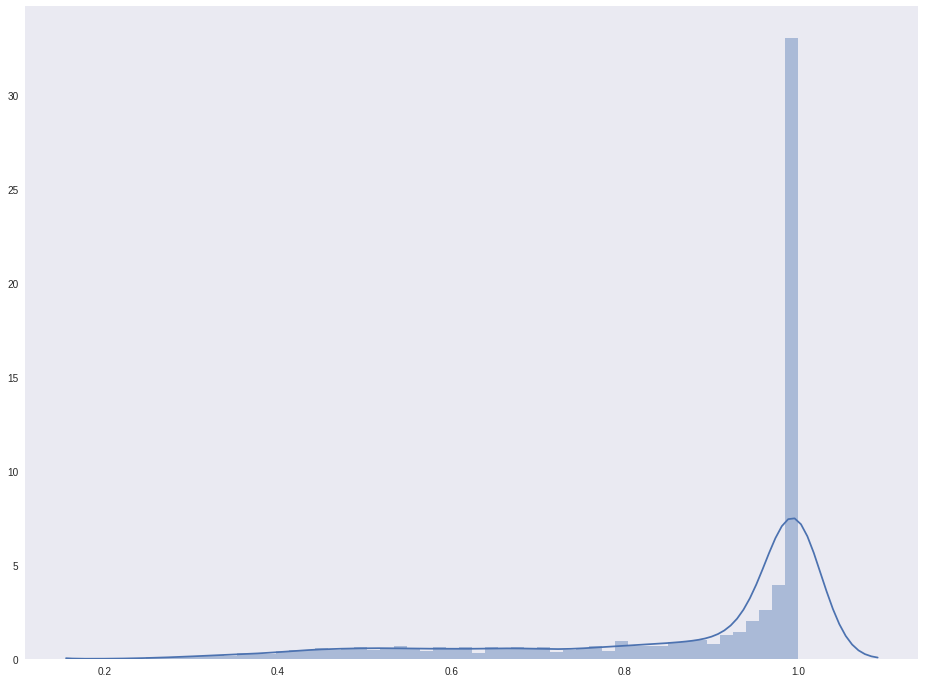

In [5]:
sns.distplot([sorted(d, key=lambda t: t[1], reverse=True)[0][1] for (f, d) in p_test.items()], bins=50)

In [10]:
threshold = 0.95

selection = [(f, sorted(d, key=lambda t: t[1], reverse=True)) for (f, d) in p_test.items() if sorted(d, key=lambda t: t[1], reverse=True)[0][1] > threshold]

In [11]:
len(selection), len(p_test)

(1602, 2640)

In [12]:
selection_argmax = [(f, d[0][0]) for (f, d) in selection]
pd.Series([c for (f, c) in selection_argmax]).value_counts()

Motorola-Nexus-6        232
Motorola-Droid-Maxx     210
Samsung-Galaxy-S4       205
iPhone-6                195
Samsung-Galaxy-Note3    181
Motorola-X              177
HTC-1-M7                166
Sony-NEX-7              127
LG-Nexus-5x              77
iPhone-4s                32
dtype: int64

In [13]:
output_dir = '/home/mephistopheies/storage2/data/camera-model-id/pseudo_labels/resnet34fc__256_pretrained_random_aug_kaggle_10__phase1'

In [14]:
classes = [os.path.basename(s) for s in glob('/home/mephistopheies/storage2/data/camera-model-id/raw/train/*')]

In [15]:
for c in classes:
    if not os.path.isdir(os.path.join(output_dir, c)):
        os.makedirs(os.path.join(output_dir, c))

In [16]:
def loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [17]:
for f, c in tqdm_notebook(selection_argmax):
    img = np.array(loader(os.path.join(test_path, 'no_class', f)))
    np.savez(os.path.join(output_dir, c, f), data=img)